In [2]:
#import libraries
import nltk, re,pprint
import numpy as np
import pandas as pd
import requests 
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

import nltk
nltk.download('treebank')

#reading the treebank tagged sentences
wsj=list(nltk.corpus.treebank.tagged_sents())

print(wsj[:40])

random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)
print(len(train_set))
print(len(test_set))
print(train_set[:40])

#getting list of tagged words
train_tagged_words=[tup for sent in train_set for tup in sent]
len(train_tagged_words)

#tokens
tokens=[pair[0] for pair in train_tagged_words]
tokens[:10]

#vocabulary
V=set(tokens)
print(len(V))

#number of tags
T=set([pair[1] for pair in train_tagged_words])
len(T)

print(T)

#emission probability
#computing P(w/t) amd starting in T x V matrix
t=len(T)
v=len(V)
w_given_t= np.zeros((t,v))

#compute word given tag: Emission Probablility 
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list =[pair for pair in train_bag if pair[1]==tag]
    count_tag=len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

#examples
#large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'),"\n")
#will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'),"\n")
#BOOK
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))

In [15]:
#transition probability
#compute tag given tag: tag2(t2) given tag1(t1), i.e. Transition Probablity
def t2_given_t1(t2,t1, train_bag=train_tagged_words):
    tags=[pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 =0;
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1]==t2:
            count_t2_t1 +=1
    return (count_t2_t1, count_t1)

In [16]:
#examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN','JJ'))
print(t2_given_t1('NN','DT'))
print(t2_given_t1('NNP','VB'))
print(t2_given_t1(',','NNP'))
print(t2_given_t1('PRP','PRP'))
print(t2_given_t1('VBG','NNP'))

(148, 4110)
(1839, 4110)
(2696, 5756)
(55, 1773)
(952, 6493)
(2, 1191)
(5, 6493)


In [17]:
#PLEASE NOTE p(TAG/START) IS SAME AS P(TAG/'.')
print(t2_given_t1('DT','.'))
print(t2_given_t1('VBG','.'))
print(t2_given_t1('NN','.'))
print(t2_given_t1('NNP','.'))

(578, 2715)
(11, 2715)
(117, 2715)
(508, 2715)


In [18]:
#CREATING TXT transition matrix of tags
#each column is t2, each row is t1
# thus M(i,j) represents P(tj given ti)
tags_matrix = np.zeros((len(T),len(T)),dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i,j]=t2_given_t1(t2,t1)[0]/t2_given_t1(t2,t1)[1]

In [19]:
tags_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04076087, 0.00543478,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03267974, 0.        ,
        0.        ],
       ...,
       [0.        , 0.00513347, 0.        , ..., 0.07340863, 0.00205339,
        0.        ],
       [0.        , 0.        , 0.0075188 , ..., 0.02255639, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00526316, 0.        ,
        0.        ]], dtype=float32)

In [20]:
tags_df= pd.DataFrame(tags_matrix, columns=list(T), index=list(T))

In [21]:
tags_df

,WP$,:,RP,DT,TO,``,.,PRP$,UH,MD,...,WP,RBS,VBZ,$,JJ,",",NNP,RB,WRB,POS
WP$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
:,0.000000,0.000000,0.000000,0.130435,0.000000,0.048913,0.010870,0.002717,0.000000,0.013587,...,0.010870,0.000000,0.010870,0.008152,0.065217,0.000000,0.149457,0.040761,0.005435,0.000000
RP,0.000000,0.000000,0.000000,0.202614,0.026144,0.019608,0.026144,0.052288,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.013072,0.045752,0.026144,0.006536,0.032680,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000869,0.000347,0.006776,0.001216,0.000000,0.000000,0.001390,...,0.000347,0.002606,0.006428,0.008687,0.205003,0.001390,0.128214,0.008687,0.000000,0.000000
TO,0.000000,0.000000,0.000000,0.121514,0.000000,0.005976,0.000000,0.017928,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.037849,0.029880,0.000000,0.045817,0.004648,0.000664,0.000000
``,0.000000,0.000000,0.000000,0.182731,0.000000,0.000000,0.000000,0.002008,0.002008,0.010040,...,0.010040,0.000000,0.016064,0.000000,0.110442,0.000000,0.068273,0.068273,0.012048,0.000000
.,0.000000,0.002947,0.000000,0.212891,0.000737,0.069245,0.000000,0.006630,0.000000,0.000000,...,0.002947,0.000737,0.002210,0.001473,0.034254,0.000000,0.187109,0.040884,0.006998,0.000000
PRP$,0.000000,0.000000,0.000000,0.000000,0.000000,0.001845,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001845,0.012915,0.226937,0.000000,0.051661,0.001845,0.000000,0.000000
UH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.003091,0.000000,0.004637,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004637,0.000000,0.165379,0.000000,0.000000


In [22]:
tags_df.loc['.', :]

WP$       0.000000
:         0.002947
RP        0.000000
DT        0.212891
TO        0.000737
``        0.069245
.         0.000000
PRP$      0.006630
UH        0.000000
MD        0.000000
VB        0.001105
NNPS      0.001842
#         0.000000
-LRB-     0.005157
-NONE-    0.020626
IN        0.122652
NNS       0.043462
LS        0.001842
RBR       0.001105
VBG       0.004052
NN        0.043094
VBD       0.000368
CC        0.047145
PDT       0.000368
VBP       0.000000
CD        0.006630
WDT       0.000000
SYM       0.000000
''        0.060405
VBN       0.001473
JJR       0.003315
EX        0.002947
PRP       0.056722
-RRB-     0.005525
FW        0.000000
JJS       0.000737
WP        0.002947
RBS       0.000737
VBZ       0.002210
$         0.001473
JJ        0.034254
,         0.000000
NNP       0.187109
RB        0.040884
WRB       0.006998
POS       0.000000
Name: ., dtype: float32

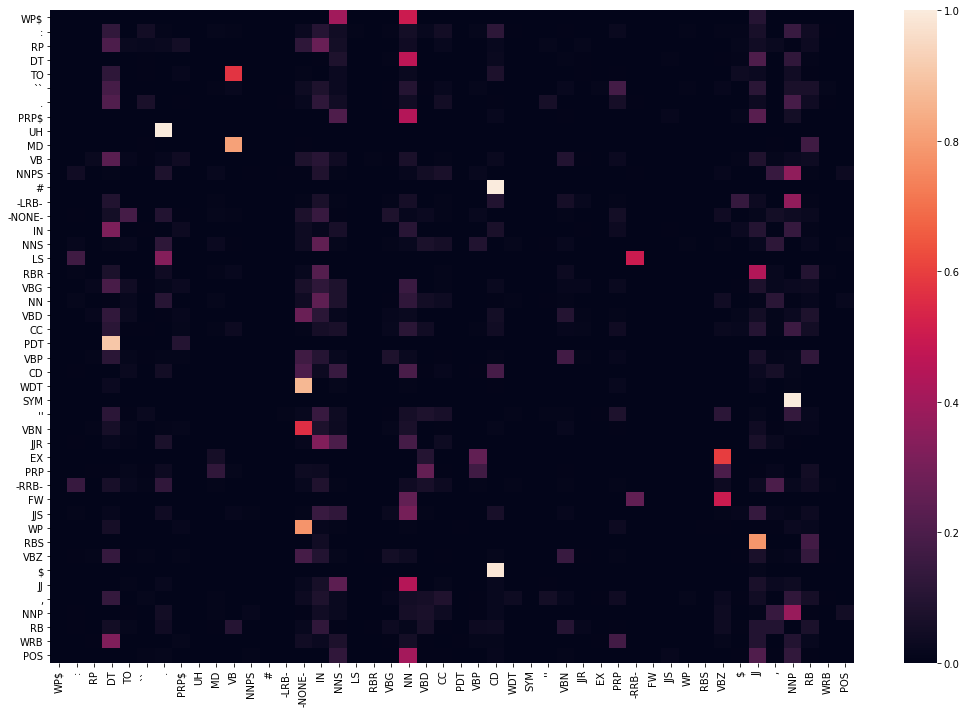

In [23]:
#heatmap of tags matrix
#T(i,j) means P(tag j given tag i)
plt.figure(figsize=(18,12))
sns.heatmap(tags_df)
plt.show()

In [24]:
#frequent tags
#filter the df to get P(t2,t1)>0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18,12))
sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

<Figure size 1296x864 with 0 Axes>

Part-of-speech (POS) tagging is a natural language processing (NLP) task that involves assigning grammatical tags to each word in a given text. The goal of POS tagging is to determine the syntactic category of each word, such as noun, verb, adjective, adverb, etc. These tags provide information about the role and function of words in a sentence, enabling further analysis and understanding of the text.

Hidden Markov Model (HMM) is a statistical model widely used in various fields, including NLP. HMM is a probabilistic model that assumes the underlying states of a system are hidden and can only be observed through a series of observable events or outputs. In the context of POS tagging, HMM is used to infer the most likely sequence of POS tags given an input sentence.

In POS tagging using HMM, the model considers a sequence of words as the input and assigns a sequence of POS tags as the output. The HMM assumes that there is a hidden Markov chain of POS tags, where each POS tag depends only on its previous POS tag. The observed words are emitted from each state (POS tag) based on their respective probabilities.

The training process involves estimating the transition probabilities between POS tags and the emission probabilities of words given a POS tag from a labeled corpus. These probabilities are then used to determine the most likely sequence of POS tags for unseen sentences.

During the tagging phase, given an input sentence, the HMM calculates the probability of different sequences of POS tags and selects the most likely sequence based on the Viterbi algorithm or other decoding techniques. This process enables the assignment of POS tags to words in the input sentence.

POS tagging with HMM is a common and effective approach for assigning grammatical tags to words in a given text, allowing for various downstream NLP tasks such as parsing, information extraction, and machine translation.